In [1]:
import tensorflow as tf
from tensorflow.keras import layers , models
import matplotlib.pyplot as plt

In [2]:
img_size = 256
btch = 32
chnl = 3
epochs = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "plantvillage",
    shuffle = True,
    image_size = (img_size,img_size),
    batch_size = btch
)

Found 2152 files belonging to 3 classes.


In [4]:
cls_names = dataset.class_names
cls_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

In [6]:
501*32

16032

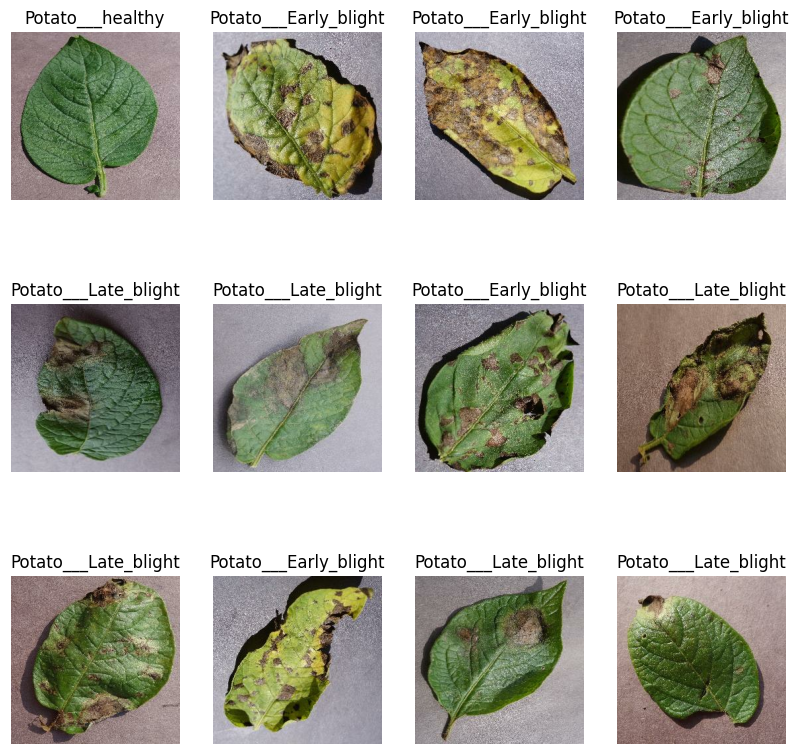

In [7]:
plt.figure(figsize=(10,10))
for image_batch , label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4 , i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(cls_names[label_batch[i]])

In [8]:
len(dataset)

68

In [9]:
# trainning size -- 80%
# validation size -- 110% 
# test size -- 10%


In [10]:
trainsize = 0.8
len(dataset)*trainsize

54.400000000000006

In [11]:
train_data = dataset.take(400)

In [12]:

remaindata = dataset.skip(400)
len(remaindata)

0

In [13]:
valsize = 0.1
valdata = remaindata.take(50)
testsize = 0.1
testdata = remaindata.skip(50)

In [14]:
def get_daataset_parttion(dataset , train_split = 0.8 , val_split = 0.1,test_split=0.1 , shuffle = True , shuffle_size = 1000):
    dtlen = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size , seed=12)
        
    trainsize = int(dtlen*train_split)
    valsize = int(dtlen*val_split)
    
    train_dt = dataset.take(trainsize)
    val_dt = dataset.skip(trainsize).take(valsize)
    test_dt = dataset.skip(trainsize).skip(valsize)
    
    return train_dt , val_dt , test_dt

In [15]:
train_dt , val_dt , test_dt = get_daataset_parttion(dataset)

In [16]:
len(test_dt)

8

In [17]:
train_dt = train_dt.cache().shuffle(1000).prefetch(buffer_size=16)
val_dt = val_dt.cache().shuffle(1000).prefetch(buffer_size=16)
test_dt  = test_dt.cache().shuffle(1000).prefetch(buffer_size=16)

In [18]:
train_dt

<PrefetchDataset shapes: ((None, 256, 256, 3), (None,)), types: (tf.float32, tf.int32)>

In [19]:
resizeandrescaled =  tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(img_size , img_size),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [20]:
# dataaug = tf.keras.Sequential([
#     layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#     layers.experimental.preprocessing.RandomRotation(0.2),
# ])

In [21]:
# train_dts = train_dt.map(lambda x, y: (dataaug(x, training=True), y), num_parallel_calls=tf.data.experimental.AUTOTUNE)
# train_dts = train_dts.prefetch(tf.data.experimental.AUTOTUNE)

In [22]:
input_shape = (btch , img_size , img_size , chnl)
model = models.Sequential([
    resizeandrescaled,
    layers.Conv2D(16,(3,3) , activation = "relu" , input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(3, activation='softmax'),
    
])
model.build(input_shape =input_shape)

In [23]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        9280      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [24]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ["accuracy"]
)

In [25]:

with tf.device('/GPU:0'):
    hist =  model.fit(
        train_dt,
        batch_size=32,
        validation_data=val_dt,
        verbose=1,
        epochs=50,
    )

Epoch 1/50
54/54 [==============================] - 27s 504ms/step - loss: 0.9016 - accuracy: 0.4907 - val_loss: 0.8821 - val_accuracy: 0.6146
Epoch 2/50
54/54 [==============================] - 11s 199ms/step - loss: 0.6412 - accuracy: 0.7182 - val_loss: 0.5441 - val_accuracy: 0.7969
Epoch 3/50
54/54 [==============================] - 5s 102ms/step - loss: 0.3716 - accuracy: 0.8524 - val_loss: 0.2230 - val_accuracy: 0.9115
Epoch 4/50
54/54 [==============================] - 6s 102ms/step - loss: 0.2465 - accuracy: 0.9057 - val_loss: 0.1509 - val_accuracy: 0.9531
Epoch 5/50
54/54 [==============================] - 5s 102ms/step - loss: 0.1944 - accuracy: 0.9271 - val_loss: 0.1114 - val_accuracy: 0.9688
Epoch 6/50
54/54 [==============================] - 5s 99ms/step - loss: 0.1727 - accuracy: 0.9282 - val_loss: 0.1167 - val_accuracy: 0.9375
Epoch 7/50
54/54 [==============================] - 5s 100ms/step - loss: 0.1332 - accuracy: 0.9450 - val_loss: 0.0816 - val_accuracy: 0.9792
Epoch

In [26]:
hist

In [27]:
hist.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [28]:
hist.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
hist.history["loss"][:5]

[0.9015745520591736,
 0.6412363648414612,
 0.37159329652786255,
 0.24650733172893524,
 0.19435885548591614]

In [30]:
acc = hist.history["accuracy"]
val_acc= hist.history["val_accuracy"]

loss = hist.history["loss"]
val_loss = hist.history["val_loss"]

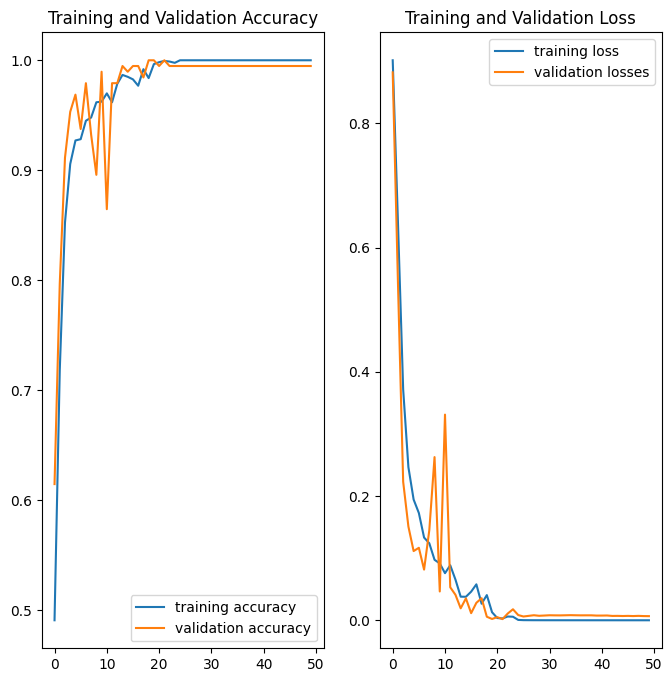

In [31]:
plt.figure(figsize = (8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs) , acc , label = "training accuracy")
plt.plot(range(epochs) , val_acc , label = "validation accuracy")
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(epochs) , loss , label = "training loss")
plt.plot(range(epochs) , val_loss , label = "validation losses")
plt.legend(loc = "upper right")
plt.title("Training and Validation Loss")
plt.show()

In [32]:
import numpy as np

first image predicted as:
actual laebl : Potato___Late_blight
predict label as: Potato___Late_blight


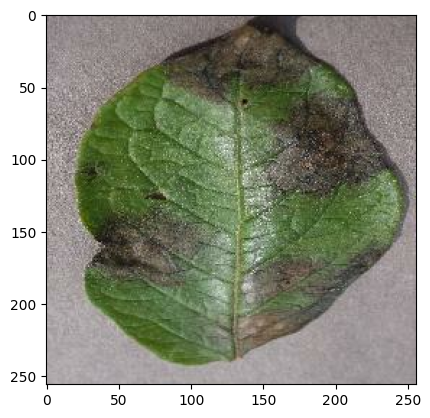

In [33]:
for image_batch , label_batch in test_dt.take(1):
    fist_img = image_batch[0].numpy().astype("uint8")
    fist_label = label_batch[0].numpy()
    
    print("first image predicted as:")
    
    plt.imshow(fist_img)
    print("actual laebl :" , cls_names[fist_label])
    
    batch_prediction = model.predict(image_batch)
    print("predict label as:" , cls_names[np.argmax(batch_prediction[0])])

In [34]:
def predict(img  , model):
    img_ary = tf.keras.preprocessing.image.img_to_array(image[i].numpy())
    img_ary = tf.expand_dims(img_ary , 0)
    
    prediction = model.predict(img_ary)
    
    predicted_cls = cls_names[np.argmax(prediction[0])]
    confidence = round(100*(np.max(prediction[0])),2)
    
    return predicted_cls , confidence

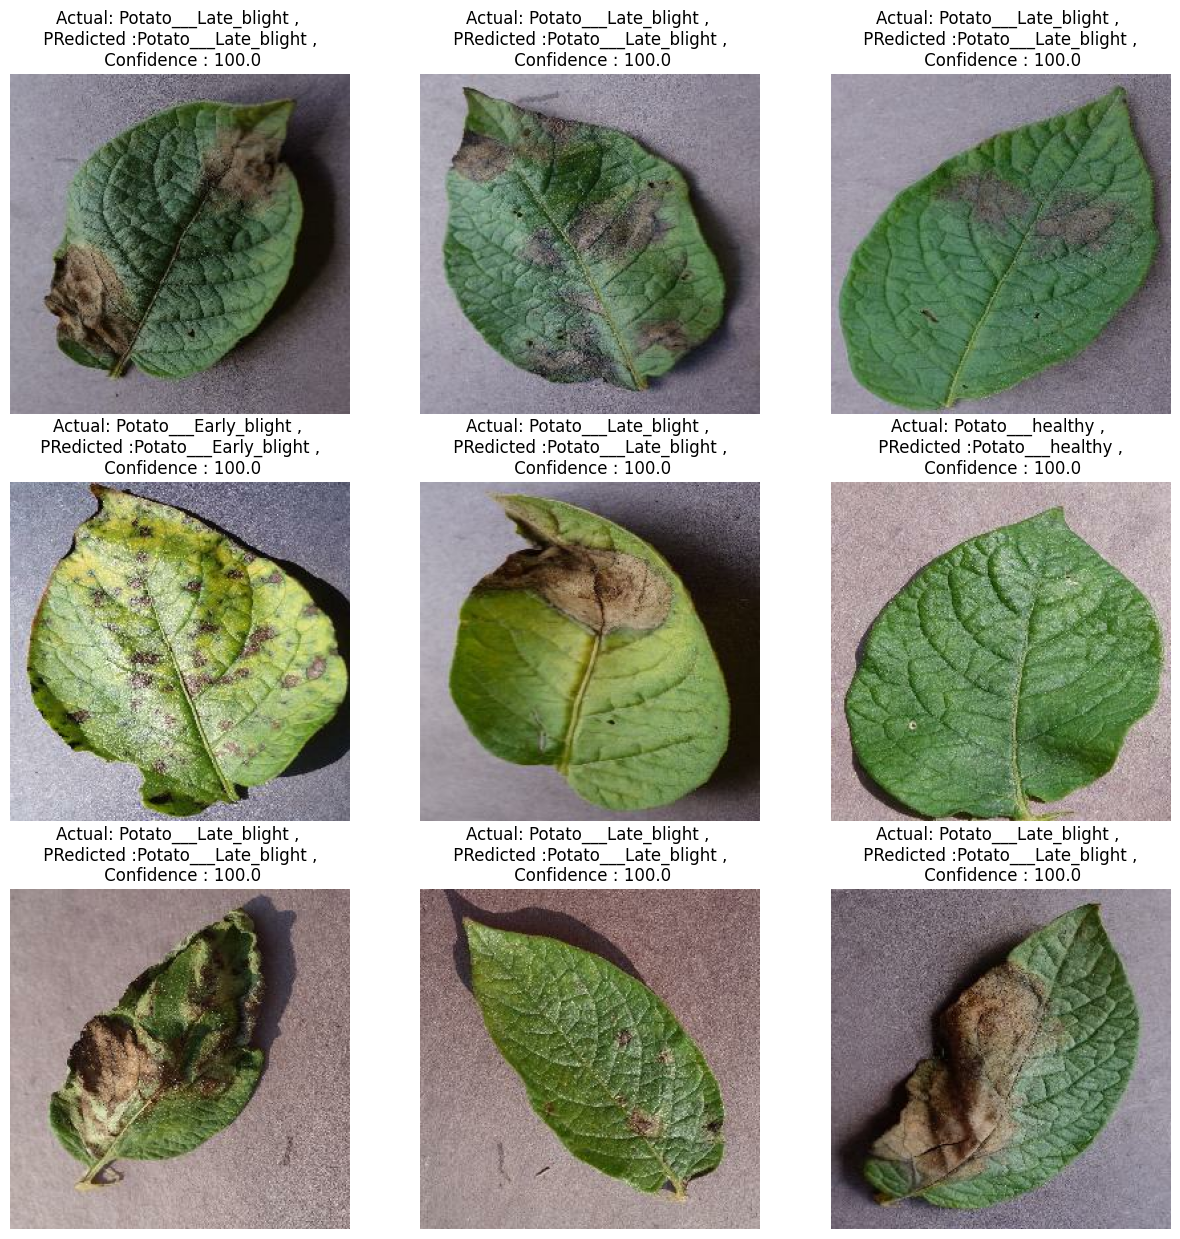

In [35]:
plt.figure(figsize = (15,15))
for image , label in test_dt.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))
        
        predicted_cls , confidence = predict(image[i].numpy(),model)
        actual_cls = cls_names[label[i]]
        
        plt.title(f"Actual: {actual_cls} , \n PRedicted :{predicted_cls} , \n Confidence : {confidence}")
        
        plt.axis("off")

In [37]:
model_version = 3

model.save(f"../model/{model_version}")

INFO:tensorflow:Assets written to: ../model/3\assets
